<a href="https://colab.research.google.com/github/NAJOO0/2022F-Ajou-ML/blob/main/baseline_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge :: Coin Classification

여러 나라의 동전 이미지를 보고 어느 나라의 동전인지 분류하는 테스크입니다.  
동전의 클래스는 인도, 유럽, 중국, 미국, 일본, 필리핀으로 총 6개 입니다.

각 나라의 label은 아래와 같이 설정합니다.
{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Drive에서 데이터 가져오기 OR 로컬에서 파일 업로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive
#'알맞은 디렉토리 채우기'

/content/drive/MyDrive


In [ ]:
ls

'baseline.ipynb의 사본'   coins_images@


In [ ]:
#util
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
#model
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
#dataset
from torchvision import transforms, utils, datasets,models
from torch.utils.data import Dataset, DataLoader
import torch.utils.data


##이미지 시각화


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # prevent truncate error

In [ ]:
import PIL
img = PIL.Image.open('./coins_images/TEST/test_30.jpg') 
tf_resize = transforms.Resize((256,256))
tf_normalize = transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
# tf2 = transforms.RandomHorizontalFlip()
# tf4 = transforms.RandomResizedCrop((224,224))
tf = transforms.ToTensor()
imgt = tf_resize(img)
imgt1=tf(imgt)
imgt2=tf(img)
# imgt3=tf4(imgt1)
# imgt=tf2(imgt)
# imgt=tf(imgt)
print(imgt1.size())
print(imgt1)

torch.Size([3, 256, 256])
tensor([[[0.6314, 0.6235, 0.6196,  ..., 0.5961, 0.5961, 0.5922],
         [0.6353, 0.6314, 0.6275,  ..., 0.5961, 0.5922, 0.5922],
         [0.6314, 0.6314, 0.6275,  ..., 0.5961, 0.5922, 0.5882],
         ...,
         [0.5961, 0.5961, 0.6039,  ..., 0.5373, 0.5373, 0.5373],
         [0.5961, 0.5961, 0.6000,  ..., 0.5294, 0.5373, 0.5333],
         [0.6039, 0.6000, 0.6039,  ..., 0.5255, 0.5333, 0.5333]],

        [[0.7059, 0.6980, 0.6941,  ..., 0.6706, 0.6706, 0.6667],
         [0.7098, 0.7059, 0.7020,  ..., 0.6706, 0.6667, 0.6667],
         [0.7059, 0.7059, 0.7020,  ..., 0.6706, 0.6667, 0.6627],
         ...,
         [0.6745, 0.6745, 0.6824,  ..., 0.6118, 0.6118, 0.6118],
         [0.6745, 0.6745, 0.6784,  ..., 0.6039, 0.6118, 0.6078],
         [0.6824, 0.6784, 0.6824,  ..., 0.6000, 0.6078, 0.6078]],

        [[0.7216, 0.7137, 0.7098,  ..., 0.6863, 0.6863, 0.6824],
         [0.7255, 0.7216, 0.7176,  ..., 0.6863, 0.6824, 0.6824],
         [0.7216, 0.7216, 0.7176

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

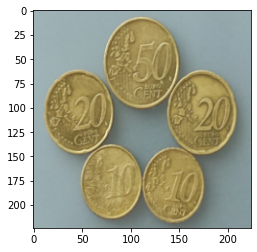

In [ ]:
imshow(imgt3)

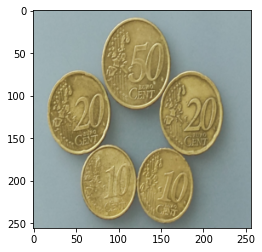

In [ ]:
imshow(imgt1)

## Load Data

In [ ]:
image_transforms = {
    "train": transforms.Compose([
             transforms.Resize((256,256)),
             transforms.RandomCrop((224,224)),
             transforms.RandomHorizontalFlip(),
            #  transforms.RandomVerticalFlip(),
             transforms.RandomRotation(90),
            #   transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
            # transforms.RandomInvert(),
            # transforms.AutoAugment(),
            
            transforms.ToTensor(),
            # transforms.RandomResizedCrop((224,224)),
        #    transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
           
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
    ])
}

In [ ]:
# From https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d

class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
train_data = ImageFolderWithPaths(root = './coins_images/' + "TRAIN", # load train data
                                   transform = image_transforms['train'],
                                  )
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True) # make train loader

In [ ]:
train_data

Dataset ImageFolderWithPaths
    Number of datapoints: 1229
    Root location: ./coins_images/TRAIN
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=None)
               RandomCrop(size=(224, 224), padding=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-90.0, 90.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
           )

In [ ]:
classes = train_data.class_to_idx # class name
classes

{'china_coins': 0,
 'euro_coins': 1,
 'indian_coins': 2,
 'peso_coins': 3,
 'us_coins': 4,
 'yen_coins': 5}

## Show Example Data

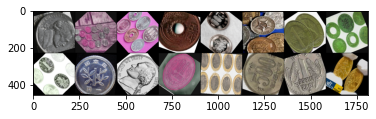


us_coins yen_coins yen_coins yen_coins yen_coins peso_coins euro_coins indian_coins china_coins yen_coins us_coins china_coins euro_coins yen_coins indian_coins euro_coins


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
# print(dataiter.next())
# images, labels, paths = dataiter.next()
images, labels, paths = next(dataiter)

batch_size = 16

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print()
labels = labels.tolist()
print(' '.join(f'{list(classes.keys())[list(classes.values()).index(j)]}' for j in labels))

##RESNET

In [ ]:
class Conv(nn.Module):
  def __init__(self,in_channels,out_channels,kernel_size=3,stride=1,padding=1):
    super().__init__()
    self.relu=nn.ReLU()
    self.conv = nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding)
    self.bn = nn.BatchNorm2d(out_channels)
  def forward(self,x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)
    return x
class BottleNeckBlock(nn.Module):
  def __init__(self,in_channels,mid_channels,out_channels,stride=1):
    super().__init__()
    self.relu = nn.ReLU()
    # if in_channels==64:
    #   self.convS = nn.Sequential(
    #         Conv(in_channels, mid_channels, kernel_size=1, padding=0),
    #         Conv(mid_channels, mid_channels, kernel_size=3, padding=1),
    #         Conv(mid_channels, out_channels, kernel_size=1, padding=0)
    #   )
    #   self.resi = nn.Conv2d(in_channels,out_channels,kernel_size=1,padding=0)
    # elif in_channels!=out_channels:
    #   self.convS = nn.Sequential(
    #         Conv(in_channels, mid_channels, kernel_size=1, padding=0),
    #         Conv(mid_channels, mid_channels, kernel_size=3, padding=1,stride=2),
    #         Conv(mid_channels, out_channels, kernel_size=1, padding=0)
    #   )
    #   self.resi = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=2,padding=0)
    # else:
    if stride!=1 or in_channels!=out_channels:
      self.convS = nn.Sequential(
            Conv(in_channels, mid_channels, kernel_size=1, padding=0),
            Conv(mid_channels, mid_channels, kernel_size=3, padding=1,stride=stride),
            Conv(mid_channels, out_channels, kernel_size=1, padding=0)
      )
      self.resi = nn.Sequential(
           nn.Conv2d(in_channels,out_channels,kernel_size=1,padding=0,stride=stride),
           nn.BatchNorm2d(out_channels)
      )
     
    elif in_channels==64:
      self.convS = nn.Sequential(
            Conv(in_channels, mid_channels, kernel_size=1, padding=0),
            Conv(mid_channels, mid_channels, kernel_size=3, padding=1),
            Conv(mid_channels, out_channels, kernel_size=1, padding=0)
      )
      self.resi = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=1,padding=0),
            nn.BatchNorm2d(out_channels)
      )
    else:
        self.convS = nn.Sequential(
            Conv(in_channels, mid_channels, kernel_size=1, padding=0),
            Conv(mid_channels, mid_channels, kernel_size=3, padding=1),
            Conv(mid_channels, out_channels, kernel_size=1, padding=0)
      )
        self.resi = nn.Sequential()
  def forward(self,x):
    x = self.convS(x) + self.resi(x)
    x = self.relu(x)
    return x
class ResNet50(nn.Module):
    def __init__(self,in_channels=3,num_classes=6):
      super().__init__()
      self.start = nn.Sequential(
          Conv(in_channels,out_channels=64,kernel_size=7,stride=2,padding=3),
         nn.MaxPool2d(3,2,1)
      )
      self.layer1 = nn.Sequential(
          BottleNeckBlock(64,64,256,1),
          BottleNeckBlock(256,64,256,1),
          BottleNeckBlock(256,64,256,1),
      )
      self.layer2 = nn.Sequential(
          BottleNeckBlock(256,128,512,2),
          BottleNeckBlock(512,128,512,1),
          BottleNeckBlock(512,128,512,1),
          BottleNeckBlock(512,128,512,1),
      )
      self.layer3 = nn.Sequential(
          BottleNeckBlock(512,256,1024,2),
          BottleNeckBlock(1024,256,1024,1),
          BottleNeckBlock(1024,256,1024,1),
          BottleNeckBlock(1024,256,1024,1),
          BottleNeckBlock(1024,256,1024,1),
          BottleNeckBlock(1024,256,1024,1),
      )
      self.layer4 = nn.Sequential(
          BottleNeckBlock(1024,512,2048,2),
          BottleNeckBlock(2048,512,2048,1),
          BottleNeckBlock(2048,512,2048,1),
      )
      self.avgpool=nn.AvgPool2d(kernel_size=7,stride=1)
      self.fc=nn.Linear(2048,num_classes) 
    def forward(self,x):
      x=self.start(x)
      x=self.layer1(x)
      x=self.layer2(x)
      x=self.layer3(x)
      x=self.layer4(x)
      x=self.avgpool(x)
      x=x.reshape(x.shape[0],-1)
      x=self.fc(x)
      return x

In [ ]:
import torch
import torchvision
import torchsummary
net = ResNet50()

torchsummary.summary(net, (3, 224, 224),device='cpu')
# print(net)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,472
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
              Conv-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
            Conv2d-6           [-1, 64, 56, 56]           4,160
       BatchNorm2d-7           [-1, 64, 56, 56]             128
              ReLU-8           [-1, 64, 56, 56]               0
              Conv-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,928
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
             Conv-13           [-1, 64, 56, 56]               0
           Conv2d-14          [-1, 256,

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것
net = net.to(device)
# PATH='/content/drive/MyDrive/fixed_resnet_sgd의 사본'
# net.load_state_dict(torch.load(PATH))

In [ ]:
net = models.resnet50(pretrained=False)
net.fc = nn.Linear(2048,6)
net.to(device)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##CutMix Mixup


In [ ]:
def rand_bbox(size, lam): # size : [B, C, H, W]
    B = size[0]
    H = size[2] # 이미지의 width
    W = size[3] # 이미지의 height

    cut_rat = np.sqrt(1. - lam)  # 패치 크기의 비율 정하기
    cut_w = np.round(W * cut_rat).astype("int32")  # 패치의 너비
    cut_h = np.round(H * cut_rat).astype("int32")  # 패치의 높이

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def mixup(x, y, num_classes=6):
    gamma = 0.0
    alpha = 1.0 - gamma
    indices = torch.randperm(x.size(0), device=device, dtype=torch.long)
    if x.size(0) != indices.size(0):
        raise RuntimeError("Size mismatch")
    y = F.one_hot(labels, num_classes=num_classes)
    perm_x = x[indices]
    perm_y = y[indices]
    return x.mul(gamma).add(perm_x, alpha=alpha), y.mul(gamma).add(perm_y, alpha=alpha)

def cutmix(x, y, num_classes=6):
    alpha = 1.0
    lamb = np.random.beta(alpha, alpha)
    indices = torch.randperm(x.size(0), device=device, dtype=torch.long)
    if x.size(0) != indices.size(0):
        raise RuntimeError("Size mismatch")
    
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lamb)
    
    x[:, :, bbx1:bbx2, bby1:bby2] = x[indices, :, bbx1:bbx2, bby1:bby2]
    y = F.one_hot(y, num_classes=num_classes)
    perm_y = y[indices]
    lamb = 1 - ((bbx2-bbx1)*(bby2-bby1) / (x.size(-1)*x.size(-2)))
    
    return x, y.mul(lamb).add(perm_y, alpha=1.-lamb)

## Define a Convolutional Neural Network

In [ ]:
from torch.nn.modules import Softmax
class VGG16(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(3,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Conv2d(64,64,3,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Conv2d(128,128,3,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(128,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256,3,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(256,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Conv2d(512,512,3,padding=1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
    )
    self.classifi = nn.Sequential(
        nn.Linear(512*7*7,4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(4096,1000),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1000,6)
    )
    self.conv1_1 = nn.Conv2d(3,64,3,padding=1)
    self.conv1_2 = nn.Conv2d(64,64,3,padding=1)

    self.conv2_1 = nn.Conv2d(64,128,3,padding=1)
    self.conv2_2 = nn.Conv2d(128,128,3,padding=1)

    self.conv3_1 = nn.Conv2d(128,256,3,padding=1)
    self.conv3_2 = nn.Conv2d(256,256,3,padding=1)
    self.conv3_3 = nn.Conv2d(256,256,3,padding=1)

    self.conv4_1 = nn.Conv2d(256,512,3,padding=1)
    self.conv4_2 = nn.Conv2d(512,512,3,padding=1)
    self.conv4_3 = nn.Conv2d(512,512,3,padding=1)

    self.conv5_1 = nn.Conv2d(512,512,3,padding=1)
    self.conv5_2 = nn.Conv2d(512,512,3,padding=1)
    self.conv5_3 = nn.Conv2d(512,512,3,padding=1)

    self.pool = nn.MaxPool2d(2,2)
    self.relu = nn.ReLU()
    self.fc1 = nn.Linear(7*7*512,4096)
    self.fc2 = nn.Linear(4096,1000)
    self.fc3 = nn.Linear(1000,6)
  def forward(self,x):
    x = self.conv(x)
    x = torch.flatten(x, 1)
    x = self.classifi(x)
    return x
    



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것
net = VGG16().to(device)
# PATH='/content/drive/MyDrive/final_vgg_sgd_nor.pt'
# net.load_state_dict(torch.load(PATH))# print(net)
# summary(net,(3,224,224),device=device.type)

In [ ]:
PATH ='/content/drive/MyDrive/test_vgg110.pt의 사본'
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
net.parameters()

<generator object Module.parameters at 0x7f56a5c44970>

In [ ]:
net = models.resnet50(pretrained=True)
net.fc = nn.Linear(2048,6)
net.to(device)

In [ ]:
import torchsummary
torchsummary.summary(net, (3, 224, 224),device=device.type)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
print(net)

##Load Network weight




In [ ]:
PATH='/content/drive/MyDrive/fixed_resnet_adamw'
net = ResNet50()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if it's available # colab 런타임 유형 변경에서 GPU 선택할 것
net = net.to(device) # send the network to the device
net.load_state_dict(torch.load(PATH))


<All keys matched successfully>

## Define a Loss function and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss() # loss function, 변경 가능
optimizer = optim.SGD(net.parameters(), lr=0.000005, momentum=0.9, weight_decay=0.0001) # optimizer, 변경 가능
# optimizer = optim.Adam(net.parameters(),lr=0.001)
# optimizer = optim.AdamW(net.parameters(),lr=0.0005)
# scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=3000,gamma=0.5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=500,T_mult=1,eta_min=1e-6)
# scheduler=optim.lr_scheduler.ReduceLROnPlateau(optimizer,"min",patience=500)

## Train the Network

In [ ]:
net.train()
current_min_loss =5
for epoch in range(10):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader, 0)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, paths = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        if i%3==0:
          inputs,labes = cutmix(inputs,labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        # scheduler.step()
        # print statistics
        running_loss += loss.item()
        # print(f"running_loss: {running_loss}")
        
        if i % 15 == 14:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
            print("lr: ", optimizer.param_groups[0]['lr'])
            if current_min_loss > running_loss:
              current_min_loss = running_loss
              print(f"current_min_loss: , {current_min_loss} epoch: {epoch+1}")
              # PATH='/content/drive/MyDrive/fixed_resnet_sgd'
              # torch.save(net.state_dict(), PATH)
            running_loss = 0.0

print('Finished Training') # epoch이 50일 때, training acc 46% 달성

  0%|          | 0/77 [00:00<?, ?it/s]

[1,    15] loss: 6.092
lr:  5e-06
[1,    30] loss: 8.296
lr:  5e-06
[1,    45] loss: 8.788
lr:  5e-06
[1,    60] loss: 6.919
lr:  5e-06
[1,    75] loss: 4.480
lr:  5e-06
current_min_loss: , 4.479713063687086 epoch: 1


  0%|          | 0/77 [00:00<?, ?it/s]

[2,    15] loss: 7.841
lr:  5e-06
[2,    30] loss: 5.179
lr:  5e-06
[2,    45] loss: 6.155
lr:  5e-06
[2,    60] loss: 8.430
lr:  5e-06
[2,    75] loss: 5.602
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[3,    15] loss: 4.833
lr:  5e-06
[3,    30] loss: 8.022
lr:  5e-06
[3,    45] loss: 8.831
lr:  5e-06
[3,    60] loss: 6.547
lr:  5e-06
[3,    75] loss: 7.450
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[4,    15] loss: 10.348
lr:  5e-06
[4,    30] loss: 6.954
lr:  5e-06
[4,    45] loss: 7.225
lr:  5e-06
[4,    60] loss: 9.320
lr:  5e-06
[4,    75] loss: 7.591
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[5,    15] loss: 7.688
lr:  5e-06
[5,    30] loss: 8.171
lr:  5e-06
[5,    45] loss: 6.979
lr:  5e-06
[5,    60] loss: 7.891
lr:  5e-06
[5,    75] loss: 8.484
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[6,    15] loss: 5.457
lr:  5e-06
[6,    30] loss: 9.053
lr:  5e-06
[6,    45] loss: 6.880
lr:  5e-06
[6,    60] loss: 6.819
lr:  5e-06
[6,    75] loss: 11.609
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[7,    15] loss: 9.846
lr:  5e-06
[7,    30] loss: 9.308
lr:  5e-06
[7,    45] loss: 5.596
lr:  5e-06
[7,    60] loss: 9.827
lr:  5e-06
[7,    75] loss: 7.254
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[8,    15] loss: 11.312
lr:  5e-06
[8,    30] loss: 8.119
lr:  5e-06
[8,    45] loss: 10.053
lr:  5e-06
[8,    60] loss: 7.751
lr:  5e-06
[8,    75] loss: 6.659
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[9,    15] loss: 7.497
lr:  5e-06
[9,    30] loss: 7.074
lr:  5e-06
[9,    45] loss: 5.779
lr:  5e-06
[9,    60] loss: 8.618
lr:  5e-06
[9,    75] loss: 8.851
lr:  5e-06


  0%|          | 0/77 [00:00<?, ?it/s]

[10,    15] loss: 7.143
lr:  5e-06
[10,    30] loss: 8.767
lr:  5e-06
[10,    45] loss: 7.423
lr:  5e-06
[10,    60] loss: 6.789
lr:  5e-06
[10,    75] loss: 8.322
lr:  5e-06
Finished Training


## Calculate Training accuracy

In [ ]:
train_test_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False) # make train_test loader

In [ ]:
correct = 0
total = 0

t=0
f=0
image_id = []
predicted_label = []
net.eval()
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(train_test_loader,0)):
        images, labels, paths = data
        images = images.to(device)
        labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        values,indexs = torch.topk(outputs.data, 1)
        if labels in indexs:
          t+=1
        else:
          f+=1
        image_id.append(paths)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(train_test_loader.dataset)} test images: {100 * correct // total} %')
print(f't:{t} f:{f}' )

  0%|          | 0/1229 [00:00<?, ?it/s]

Accuracy of the network on the 1229 test images: 97 %
t:1202 f:27


## Save the Network

In [ ]:
# # save the trained model
# PATH = './net_pretrained.pth'
# torch.save(net.state_dict(), PATH)

In [ ]:
PATH='/content/drive/MyDrive/res_adam_40'
torch.save(net,PATH)

## Testing & Making a Submission File

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset
import os

class testDataset(Dataset):
    def __init__(self, data_dir, transform):
        # path to images
        path2data = os.path.join(data_dir)

        # get a list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]
        
        # set transformations
        self.transform = transform

    def __len__(self):
        # return size of dataset
        return len(self.full_filenames)

    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])
        image = self.transform(image)
        image_name = self.full_filenames[idx]
        return image, image_name

In [ ]:
test_data = testDataset('coins_images/TEST/',image_transforms['test'])
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False) # ALWAYS SET SHUFFLE FALSE

In [ ]:
total=0
correct=0
image_id = []
predicted_label = []
with torch.no_grad(): # since we're not training, we don't need to calculate the gradients for our outputs
    for i, data in enumerate(tqdm(test_loader,0)):
        images, paths = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        path = os.path.basename(paths[0])
        image_id.append(path)
        predicted_label.append(predicted.item())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # print('path:', paths, 'predicted_label:', predicted)
print(f'Accuracy of the network on the {len(test_loader.dataset)} test images: {100 * correct // total} %')

  0%|          | 0/120 [00:00<?, ?it/s]

Accuracy of the network on the 120 test images: 15 %


In [ ]:
predicted_df = pd.DataFrame({'image_id': image_id, 'predicted_label': predicted_label})

In [ ]:
predicted_df['predicted_label'] = predicted_df.predicted_label.astype(str)

In [ ]:
predicted_df.to_csv('prediction_result.csv', index=False)